In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings 
from netCDF4 import default_fillvals

from parameter_functions_v2 import pick_dominant_pft

# define fillvals
fillval_f = default_fillvals['f8']
fillval_i = default_fillvals['i4']

__set directories and DPI for plots__

In [2]:
plot_direc = '/u/home/gergel/data/parameters/plots'
dpi = 200

# directory to write hydroclimate mask files
direc = '/u/home/gergel/data/parameters'

__Set resolution for filenames__

In [3]:
res = '50km'

# set file extensions 
if res == "50km":
    grid = 'wr50a_ar9v4'
elif res == "25km":
    grid = 'wr25b_ar9v4'
elif res == "10km":
    raise ValueError("we do not have a domain file at %s so this option has not been implemented" %res)
print("calculating parameters at %s" %res)

calculating parameters at 50km


__Set domain file__

In [4]:
if res == '50km':
    domain = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters', 
                                      'domain.lnd.wr50a_ar9v4.100920.nc'))
elif res == "25km":
    domain = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters', 
                                      'domain.lnd.wr25b_ar9v4.170413.nc'))
mask_vals = domain['mask'].values

__load all data used for climate classifications__

In [5]:
# load koppen geiger 
koppen = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/koppen_geiger', 
                                      'sdat_10012_1_20180605_141737329_%s.nc' %grid))

# Brown et al 1998 permafrost map
brown_filename = 'NCSCDv2_Circumpolar_WGS84_pfregion_extent_005deg_%s.nc' %grid
brown = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/brown_permafrost', 
                                     brown_filename))
'''# soil class
soil_class = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/soil_data/rasm_grid_netcdfs', 
                                          'soil_class_%s.nc' %grid))'''

# PFTs
pfts_data_dir = '/u/home/gergel/data/parameters/pfts/regridded_pfts'
pfts_filename = 'mksrf_landuse_rc2000_c110913_%s.nc' %grid
veg_data = xr.open_dataset(os.path.join(pfts_data_dir, pfts_filename))

# GTOPO
gtopo_filename = 'sdat_10003_1_20180525_151136146_%s.nc' %grid
gtopo = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/gtopo30', gtopo_filename))
elev = gtopo['Band1']

# World Clim data
clim_direc = '/u/home/gergel/data/parameters/world_clim_data/%s' %res
temp = xr.open_mfdataset(os.path.join(clim_direc, 'tavg*'),
                                      concat_dim='time', 
                                      data_vars='all', 
                                      coords='all')
tavg = temp['tavg'].mean('time')

__calculate dominant PFT__

In [6]:
dominant_pft = xr.apply_ufunc(pick_dominant_pft, 
                              veg_data['PCT_PFT'].where(domain.mask == 1),
                              dask='allowed',
                              input_core_dims=[['pft']],
                              vectorize=True)

__plot Arctic hydroclimate factors__

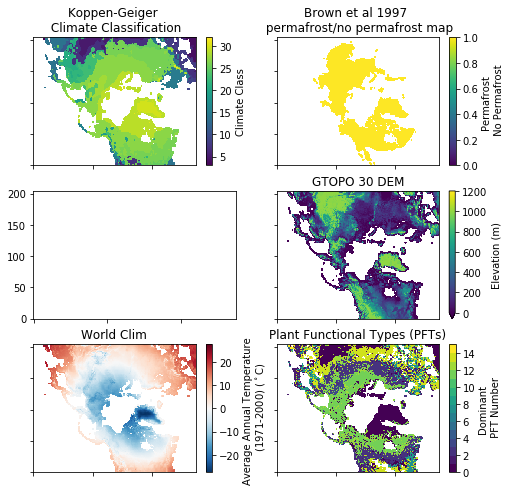

In [7]:
nrows = 3
ncols = 2
width = 8
height = 8

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(width, height),
                                 sharex=True, sharey=True)

# Koppen Geiger classification
plt.sca(axes[0, 0])
koppen['Band1'].where(domain.mask == 1).plot(add_labels=False, cbar_kwargs={'label': 'Climate Class'})
axes[0, 0].set_title('Koppen-Geiger \n Climate Classification')
plt.setp(axes[0, 0].get_xticklabels(), visible=False)
plt.setp(axes[0, 0].get_yticklabels(), visible=False)

# Brown et al 1997 permafrost/no permafrost
plt.sca(axes[0, 1])
brown['NCSCDv2'].plot(add_labels=False, vmin=0, vmax=1, 
                      cbar_kwargs={'label': 'Permafrost \n No Permafrost'})
axes[0, 1].set_title('Brown et al 1997 \n permafrost/no permafrost map')

# most probable soil class
'''plt.sca(axes[1, 0])
soil_class['soil_class'].where(domain.mask == 1).plot(levels=15, add_labels=False, 
                                                      cbar_kwargs={'label': 'Soil Class'})
axes[1, 0].set_title('ISRIC Most Probable Soil Class')
plt.setp(axes[1, 0].get_xticklabels(), visible=False)
plt.setp(axes[1, 0].get_yticklabels(), visible=False)'''

# elevation
plt.sca(axes[1, 1])
gtopo['Band1'].where(domain.mask == 1).plot(add_labels=False, 
                                            cbar_kwargs={'label': 'Elevation (m)'}, 
                                            vmin = 0, 
                                            vmax = 1200)
axes[1, 1].set_title('GTOPO 30 DEM')

# annual temperature
plt.sca(axes[2, 0])
cbar_label = 'Average Annual Temperature \n (1971-2000) ($^\circ$C)'
tavg.where(domain.mask == 1).plot(add_labels=False, 
                                  cbar_kwargs={'label': cbar_label})
axes[2, 0].set_title('World Clim')
plt.setp(axes[2, 0].get_xticklabels(), visible=False)
plt.setp(axes[2, 0].get_yticklabels(), visible=False)

# PFTs
plt.sca(axes[2, 1])
dominant_pft.where(domain.mask == 1).plot(levels=17, 
                                          cbar_kwargs={'label': 'Dominant \n PFT Number'}, 
                                          add_labels=False)
axes[2, 1].set_title('Plant Functional Types (PFTs)')
plt.setp(axes[2, 1].get_xticklabels(), visible=False)
plt.setp(axes[2, 1].get_yticklabels(), visible=False)

plotname = 'arctic_hydroclimate_factors_%s.png' %grid
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

__list of hydroclimate classes__

-- arid<br/>
-- polar<br/>
-- temperate/dry<br/>
-- cold/dry | permafrost<br/>
-- cold/dry | no permafrost<br/>
-- cold no dry season warm summers | permafrost<br/>
-- cold no dry season warm summers | no permafrost<br/>
-- cold no dry season cold summer/winter | permafrost<br/>
-- cold no dry season cold summer/winter | no permafrost<br/>

__make hydroclimate classes and plot them__

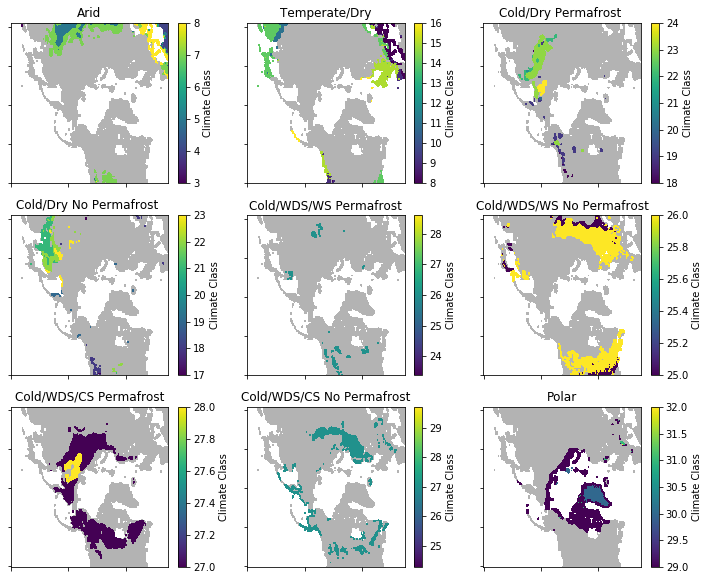

In [8]:
# figure specs
nrows = 3
ncols = 3
width = 12
height = 10

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                                 figsize=(width, height),
                                 sharex=True, sharey=True)

# arid
plt.sca(axes[0, 0])
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
arid = (domain.mask == 1) & (koppen.Band1 <= 8)
koppen['Band1'].where(arid).plot(add_labels=False, 
                                 cbar_kwargs={'label': 'Climate Class'})
axes[0, 0].set_title('Arid')
plt.setp(axes[0, 0].get_xticklabels(), visible=False)
plt.setp(axes[0, 0].get_yticklabels(), visible=False)

# temperate/dry
plt.sca(axes[0, 1])
temp_dry = (domain.mask == 1) & (koppen.Band1 >= 8) & (koppen.Band1 <= 16)
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(temp_dry).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[0, 1].set_title('Temperate/Dry')
plt.setp(axes[0, 1].get_xticklabels(), visible=False)
plt.setp(axes[0, 1].get_yticklabels(), visible=False)

# cold/dry with permafrost 
plt.sca(axes[0, 2])
cold_dry_perma = ((domain.mask == 1) & (koppen.Band1 >= 17) & (koppen.Band1 <= 24) & 
                 (brown['NCSCDv2'] == 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_perma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[0, 2].set_title('Cold/Dry Permafrost ')
plt.setp(axes[0, 2].get_xticklabels(), visible=False)
plt.setp(axes[0, 2].get_yticklabels(), visible=False)

# cold/dry without permafrost 
plt.sca(axes[1, 0])
cold_dry_noperma = ((domain.mask == 1) & (koppen.Band1 >= 17) & (koppen.Band1 <= 24) & 
                 (brown['NCSCDv2'] != 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_noperma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[1, 0].set_title('Cold/Dry No Permafrost ')
plt.setp(axes[1, 0].get_xticklabels(), visible=False)
plt.setp(axes[1, 0].get_yticklabels(), visible=False)

# Cold/WDS/WS Permafrost
plt.sca(axes[1, 1])
cold_dry_nodry1_perma = ((domain.mask == 1) & (koppen.Band1 >= 25) 
                         & (koppen.Band1 <= 26) & (brown['NCSCDv2'] == 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_nodry1_perma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[1, 1].set_title('Cold/WDS/WS Permafrost')
plt.setp(axes[1, 0].get_xticklabels(), visible=False)
plt.setp(axes[1, 0].get_yticklabels(), visible=False)

# Cold/WDS/WS No Permafrost
plt.sca(axes[1, 2])
cold_dry_nodry1_noperma = ((domain.mask == 1) & (koppen.Band1 >= 25) 
                         & (koppen.Band1 <= 26) & (brown['NCSCDv2'] != 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_nodry1_noperma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[1, 2].set_title('Cold/WDS/WS No Permafrost')
plt.setp(axes[1, 2].get_xticklabels(), visible=False)
plt.setp(axes[1, 2].get_yticklabels(), visible=False)

# Cold/WDS/cold summers Permafrost
plt.sca(axes[2, 0])
cold_dry_nodry2_perma = ((domain.mask == 1) & (koppen.Band1 >= 27) 
                         & (koppen.Band1 <= 28) & (brown['NCSCDv2'] == 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_nodry2_perma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[2, 0].set_title('Cold/WDS/CS Permafrost')
plt.setp(axes[2, 0].get_xticklabels(), visible=False)
plt.setp(axes[2, 0].get_yticklabels(), visible=False)

# Cold/WDS/cold summers Permafrost
plt.sca(axes[2, 1])
cold_dry_nodry2_noperma = ((domain.mask == 1) & (koppen.Band1 >= 27) 
                         & (koppen.Band1 <= 28) & (brown['NCSCDv2'] != 1))
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(cold_dry_nodry2_noperma).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[2, 1].set_title('Cold/WDS/CS No Permafrost')
plt.setp(axes[2, 1].get_xticklabels(), visible=False)
plt.setp(axes[2, 1].get_yticklabels(), visible=False)

# polar
plt.sca(axes[2, 2])
polar = (domain.mask == 1) & (koppen.Band1 >= 29) & (koppen.Band1 <= 32)
domain.mask.where(domain.mask == 1).plot(add_labels=False, 
                                         cmap='Set2_r', add_colorbar=False)
koppen['Band1'].where(polar).plot(add_labels=False, 
                                     cbar_kwargs={'label': 'Climate Class'})
axes[2, 2].set_title('Polar')
plt.setp(axes[2, 2].get_xticklabels(), visible=False)
plt.setp(axes[2, 2].get_yticklabels(), visible=False)

plotname = 'arctic_hydroclimate_classes_%s.png' %grid
savepath = os.path.join(plot_direc, plotname)
plt.savefig(savepath, format='png', dpi=dpi, bbox_inches='tight')

__make NetCDF of masks for each climate class__

In [9]:
masks = xr.Dataset()

masks['mask_land'] = xr.DataArray(mask_vals,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "land mask", 
                                          'units': "N/A", 'long_name': "gridcells that are land"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['arid'] = xr.DataArray(arid,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "arid mask", 
                                          'units': "N/A", 'long_name': "arid mask"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['temperate_dry'] = xr.DataArray(temp_dry,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "temperate/dry mask", 
                                          'units': "N/A", 'long_name': "arid mask"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_dry_perma'] = xr.DataArray(cold_dry_perma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/dry perma", 
                                          'units': "N/A", 'long_name': "cold and dry with permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_dry_noperma'] = xr.DataArray(cold_dry_noperma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/dry no perma", 
                                          'units': "N/A", 'long_name': "cold and dry no permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_wds_ws_perma'] = xr.DataArray(cold_dry_nodry1_perma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/wds/ws perma", 
                                          'units': "N/A", 'long_name': "Cold/Without Dry Season/Warm Summers with permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_wds_ws_noperma'] = xr.DataArray(cold_dry_nodry1_noperma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/wds/ws no perma", 
                                          'units': "N/A", 'long_name': "Cold/Without Dry Season/Warm Summers no permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_wds_cs_perma'] = xr.DataArray(cold_dry_nodry2_perma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/wds/cs perma", 
                                          'units': "N/A", 'long_name': "Cold/Without Dry Season/Cold Summers with permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['cold_wds_cs_noperma'] = xr.DataArray(cold_dry_nodry2_noperma,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "cold/wds/cs no perma", 
                                          'units': "N/A", 'long_name': "Cold/Without Dry Season/Cold Summers no permafrost"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

masks['polar'] = xr.DataArray(polar,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "polar mask", 
                                          'units': "N/A", 'long_name': "polar"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

__write hydroclimate masks to NetCDF titled `hydroclimate_masks_%grid.nc`__

In [10]:
encoding_masks = {'mask_land': {'dtype': 'int32', "_FillValue": fillval_i},
                   'arid': {'dtype': 'int32', "_FillValue": fillval_i},
                   'temperate_dry': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_dry_perma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_dry_noperma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_wds_ws_perma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_wds_ws_noperma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_wds_cs_perma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'cold_wds_cs_noperma': {'dtype': 'int32', "_FillValue": fillval_i},
                   'polar': {'dtype': 'int32', "_FillValue": fillval_i}}
new_params_file = os.path.join(direc, 'hydroclimate_masks_%s.nc' %grid)
masks.to_netcdf(new_params_file, format='NETCDF4_CLASSIC', encoding=encoding_masks)

double check to be sure that all gridcells have been included in the hydroclimate classes 

(verdict is YES)

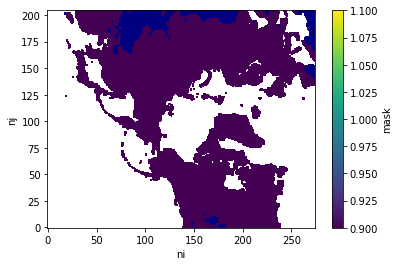

In [11]:
domain.mask.where(domain.mask == 1).plot(cmap='viridis')
masks.arid.where(masks.arid == 1).plot(cmap='jet', add_colorbar=False)
masks.temperate_dry.where(masks.temperate_dry == 1).plot(add_colorbar=False)
masks.cold_dry_perma.where(masks.cold_dry_perma == 1).plot(add_colorbar=False)
masks.cold_dry_noperma.where(masks.cold_dry_noperma == 1).plot(add_colorbar=False)
masks.cold_wds_ws_perma.where(masks.cold_wds_ws_perma == 1).plot(add_colorbar=False)
masks.cold_wds_ws_noperma.where(masks.cold_wds_ws_noperma == 1).plot(add_colorbar=False)
masks.cold_wds_cs_perma.where(masks.cold_wds_cs_perma == 1).plot(add_colorbar=False)
masks.cold_wds_cs_noperma.where(masks.cold_wds_cs_noperma == 1).plot(add_colorbar=False)
masks.polar.where(masks.polar == 1).plot(add_colorbar=False)